# SentenceTransformer fine-tuning (binary classification)
Fine-tune a sentence-transformer for the synthetic binary labels. Supports freezing the encoder to only train the classifier head; extendable to LoRA if desired.


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, losses, evaluation, InputExample
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


/var/git/genai-project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Params
DATA_PATH = Path('../data/synthetic_normal_2_labeled.csv')
MODEL_NAME = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
TEST_SIZE = 0.2
VAL_SIZE = 0.1
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 5e-5
ENCODER_LR = 5e-5 
WEIGHT_DECAY = 0.01
FREEZE_ENCODER = True
UNFREEZE_LAST_N = 1 
SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using device: {DEVICE}')

Using device: cuda


In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [4]:
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Missing dataset at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df['sentence'] = df['sentence'].astype(str)
df['label'] = df['label'].astype(int)
print(df['label'].value_counts(normalize=True))


label
1    0.500008
0    0.499992
Name: proportion, dtype: float64


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['sentence'], df['label'], test_size=TEST_SIZE, random_state=SEED, stratify=df['label']
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE, random_state=SEED, stratify=y_train
)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 45968, Val: 5108, Test: 12769


In [6]:
train_examples = [InputExample(texts=[s], label=int(l)) for s, l in zip(X_train, y_train)]
val_examples = [InputExample(texts=[s], label=int(l)) for s, l in zip(X_val, y_val)]
test_examples = [InputExample(texts=[s], label=int(l)) for s, l in zip(X_test, y_test)]


In [7]:
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

transformer = model[0]


for p in transformer.auto_model.parameters():
    p.requires_grad = False

if FREEZE_ENCODER:
    print('Encoder frozen; only classifier head will be trained')


def unfreeze_last_n_layers(transformer, n):
    if n <= 0:
        return []
    if hasattr(transformer.auto_model, "encoder") and hasattr(transformer.auto_model.encoder, "layer"):
        layers = transformer.auto_model.encoder.layer
    elif hasattr(transformer.auto_model, "transformer") and hasattr(transformer.auto_model.transformer, "layer"):
        layers = transformer.auto_model.transformer.layer
    elif hasattr(transformer.auto_model, "layer"):
        layers = transformer.auto_model.layer
    else:
        layers = None

    names = []
    if layers is not None:
        for layer in layers[-n:]:
            for p in layer.parameters():
                p.requires_grad = True
        names = [name for name, p in transformer.auto_model.named_parameters() if p.requires_grad]
        return names

    total = getattr(transformer.auto_model, 'config').num_hidden_layers if hasattr(transformer.auto_model, 'config') else None
    if total is not None:
        for name, p in transformer.auto_model.named_parameters():
            if any(f"layer.{i}." in name for i in range(total - n, total)):
                p.requires_grad = True
                names.append(name)
    return names

if UNFREEZE_LAST_N > 0:
    trainable_encoder_names = unfreeze_last_n_layers(transformer, UNFREEZE_LAST_N)
    print(f"Unfroze last {UNFREEZE_LAST_N} encoder layers. Trainable encoder params: {len(trainable_encoder_names)}")
else:
    trainable_encoder_names = []

Encoder frozen; only classifier head will be trained
Unfroze last 1 encoder layers. Trainable encoder params: 16


In [8]:
def collate_fn(batch):
    sentences = [ex.texts[0] if isinstance(ex.texts, (list, tuple)) else ex.texts for ex in batch]
    labels = torch.tensor([int(ex.label) for ex in batch], dtype=torch.long)
    features = model.tokenize(sentences)
    return features, labels

train_dataloader = DataLoader(
    train_examples,
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
)

val_sentences = list(X_val)
val_labels = list(map(int, y_val))


In [9]:
embed_dim = model.get_sentence_embedding_dimension()
classifier = torch.nn.Linear(embed_dim, 2).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()


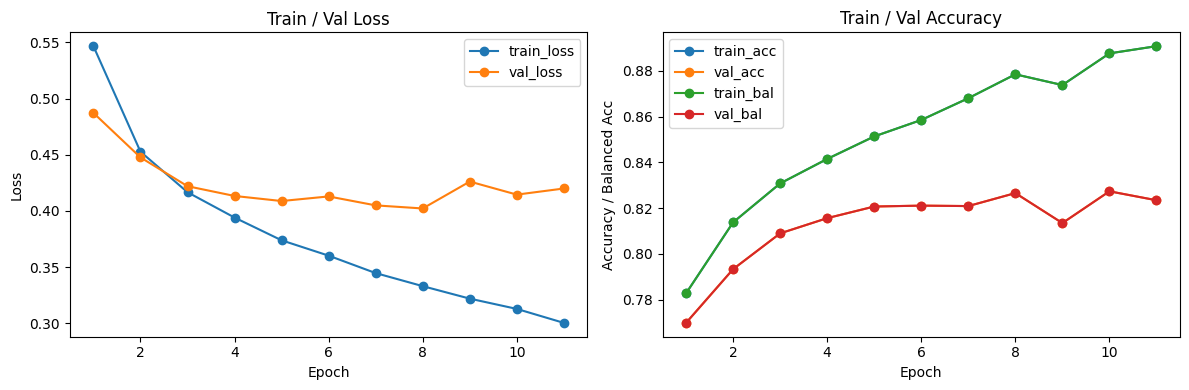

Epoch 11/100 - loss 0.3003 train_acc 0.891 train_bal 0.891 val_acc 0.823 val_bal 0.823 val_loss 0.4199
Early stopping at epoch 11 (patience=3)


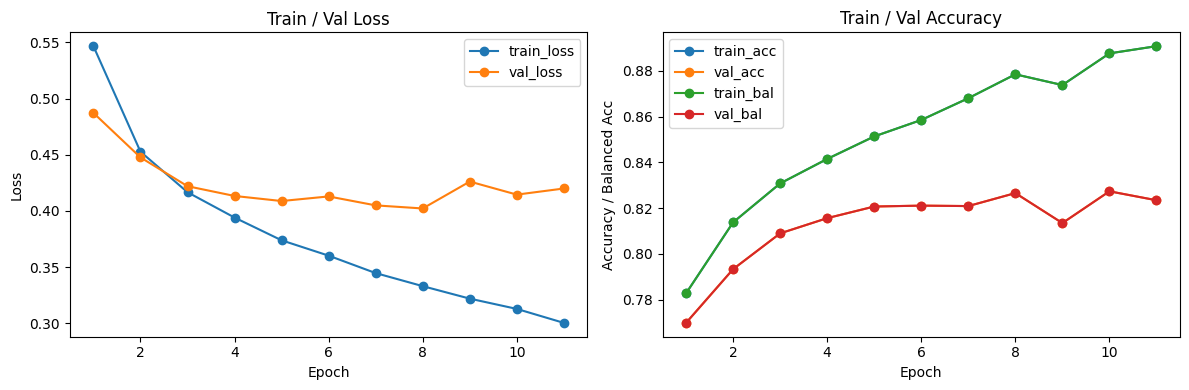

In [10]:

from torch.optim import AdamW
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import torch.nn.functional as F


encoder_trainable = [p for p in model.parameters() if p.requires_grad]
head_params = list(classifier.parameters())

if UNFREEZE_LAST_N > 0 and len(encoder_trainable) > 0:

    optimizer = AdamW([
        {"params": encoder_trainable, "lr": ENCODER_LR},
        {"params": head_params, "lr": LEARNING_RATE},
    ], weight_decay=WEIGHT_DECAY)
else:
    optimizer = AdamW([p for p in encoder_trainable + head_params if p.requires_grad], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print(f"Optimizer groups: encoder params={len(encoder_trainable)}, head params={sum(1 for p in head_params if p.requires_grad)}")
print(f"Total trainable params: {sum(1 for p in list(model.parameters()) + head_params if p.requires_grad)}")


def forward_batch(features):
    features = {k: v.to(DEVICE) for k, v in features.items()}
    emb = model(features)['sentence_embedding']
    logits = classifier(emb)
    return logits


def eval_split(sentences, labels):
    model.eval()
    classifier.eval()
    all_logits = []
    with torch.no_grad():
        for i in range(0, len(sentences), BATCH_SIZE):
            batch_sents = sentences[i:i+BATCH_SIZE]
            feats = model.tokenize(batch_sents)
            logits = forward_batch(feats)
            all_logits.append(logits.cpu())
    logits = torch.cat(all_logits)
    preds = logits.argmax(dim=1).numpy()
    acc = accuracy_score(labels, preds)
    bal = balanced_accuracy_score(labels, preds)
    return acc, bal


train_loss_hist, train_acc_hist, train_bal_hist = [], [], []
val_acc_hist, val_bal_hist, val_loss_hist = [], [], []
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

patience = 3
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
best_state = None

def plot_live(epochs_ran):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot(epochs_ran, train_loss_hist, marker='o', label='train_loss')
    axes[0].plot(epochs_ran, val_loss_hist, marker='o', label='val_loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train / Val Loss')
    axes[0].legend()

    axes[1].plot(epochs_ran, train_acc_hist, marker='o', label='train_acc')
    axes[1].plot(epochs_ran, val_acc_hist, marker='o', label='val_acc')
    axes[1].plot(epochs_ran, train_bal_hist, marker='o', label='train_bal')
    axes[1].plot(epochs_ran, val_bal_hist, marker='o', label='val_bal')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy / Balanced Acc')
    axes[1].set_title('Train / Val Accuracy')
    axes[1].legend()

    plt.tight_layout()
    clear_output(wait=True)
    display(fig)

for epoch in range(EPOCHS):
    model.train()
    classifier.train()
    total_loss = 0.0
    for features, labels in train_dataloader:
        labels = labels.to(DEVICE)
        logits = forward_batch(features)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_acc, train_bal = eval_split(list(X_train), list(map(int, y_train)))
    val_acc, val_bal = eval_split(val_sentences, val_labels)

    train_loss_hist.append(avg_loss)
    train_acc_hist.append(train_acc)
    train_bal_hist.append(train_bal)
    val_acc_hist.append(val_acc)
    val_bal_hist.append(val_bal)


    model.eval(); classifier.eval()
    with torch.no_grad():
        val_logits = []
        val_targets = []
        for i in range(0, len(val_sentences), BATCH_SIZE):
            batch_sents = val_sentences[i:i+BATCH_SIZE]
            batch_labels = torch.tensor(val_labels[i:i+BATCH_SIZE], device=DEVICE)
            feats = model.tokenize(batch_sents)
            logits = forward_batch(feats)
            val_logits.append(logits.cpu())
            val_targets.append(batch_labels.cpu())
        val_logits = torch.cat(val_logits)
        val_targets = torch.cat(val_targets)
        val_loss = criterion(val_logits, val_targets).item()
    val_loss_hist.append(val_loss)

    improved = val_loss + min_delta < best_val_loss
    if improved:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_state = {
            'model': {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
            'classifier': {k: v.detach().cpu().clone() for k, v in classifier.state_dict().items()},
        }
    else:
        epochs_no_improve += 1

    epochs_ran = range(1, len(train_loss_hist) + 1)
    plot_live(epochs_ran)

    print(f"Epoch {epoch+1}/{EPOCHS} - loss {avg_loss:.4f} "
          f"train_acc {train_acc:.3f} train_bal {train_bal:.3f} "
          f"val_acc {val_acc:.3f} val_bal {val_bal:.3f} val_loss {val_loss:.4f}")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} (patience={patience})")
        break

if best_state:
    model.load_state_dict(best_state['model'])
    classifier.load_state_dict(best_state['classifier'])

In [11]:
from sklearn.metrics import classification_report, balanced_accuracy_score

test_sentences = list(X_test)
test_labels = list(map(int, y_test))
model.eval(); classifier.eval()
all_logits = []
with torch.no_grad():
    for i in range(0, len(test_sentences), BATCH_SIZE):
        batch_sents = test_sentences[i:i+BATCH_SIZE]
        feats = model.tokenize(batch_sents)
        logits = forward_batch(feats)
        all_logits.append(logits.cpu())
logits = torch.cat(all_logits)
probs = torch.softmax(logits, dim=1)
preds = probs.argmax(dim=1).numpy()

print('Balanced accuracy:', balanced_accuracy_score(test_labels, preds))
print('\nClassification report:\n')
print(classification_report(test_labels, preds, digits=3))


Balanced accuracy: 0.8338939066538704

Classification report:

              precision    recall  f1-score   support

           0      0.840     0.825     0.832      6384
           1      0.828     0.843     0.835      6385

    accuracy                          0.834     12769
   macro avg      0.834     0.834     0.834     12769
weighted avg      0.834     0.834     0.834     12769

